In [118]:
# ===== INPUT FIELD ===================================
IS_COMPLEX          = True
SAMPLE_DATA_CSV     = 'src/sample_data.csv'
# =====================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings

import xgboost as xgb
from xgboost import XGBRegressor

# Library Setup
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)

In [119]:
# Column Names and Mapping
DEMO_FEATURES       = ['AGE', 'SEX', 'BMI', 'CHARLSON']
CANCER_FEATURES     = ['CANCER_TYPE', 'CANCER_STAGE', 'SUV_MAX']
MOLECULAR_FEATURES  = ['EGFR_ANY', 'EGFR_G719X', 'EGFR_E19DEL', 'EGFR_T790M', 'EGFR_S768I', 'EGFR_E20INS', 'EGFR_L858R', 'EGFR_L861Q', 'ALK', 'PD_L1']
OP_FEATURES         = ['OP_RESECTION', 'OP_NEOADJ']
CHEMO_FEATURES      = ['CYTO_PLAT', 'CYTO_ALKYL', 'CYTO_TOPO', 'CYTO_METABOL', 'CYTO_MITO', 'EGFR_TKI', 'ALK_TKI', 'OTHER_TARGET', 'IMMUNE']
RT_FEATURES         = ['RT', 'RT_GY', 'RT_FX']
RESPONSE_FEATURES   = ['RECIST', 'SUV_MAX_POST']

INP_FEATURES = DEMO_FEATURES + CANCER_FEATURES + MOLECULAR_FEATURES
if IS_COMPLEX:
    INP_FEATURES += OP_FEATURES + CHEMO_FEATURES + RT_FEATURES + RESPONSE_FEATURES

CANCER_TYPE_MAP = {
    'ADC': 1, 'ADENO': 1, 'ADENOCA':1, 'ADENOCARCINOMA': 1,
    'SQC': 2, 'SQCC': 2, 'SQUAMOUS CELL CARCINOMA': 2,
}
CANCER_STAGE_MAP = {
    'IA': 1, 'IB': 2, 'IIA': 3, 'IIB': 4,
    'IIIA': 5, 'IIIB': 6, 'IIIC': 7, 'IVA': 8, 'IVB': 9
}
RECIST_MAP = {
    'NED': 1, 'CR': 1, 'PR': 2, 'SD': 3, 'PD': 4
}

# Load Data and Preprocess
def load_data(filename):
    df = pd.read_csv(filename, encoding='utf-8')
    
    df['SEX']           = df['SEX'].map({'M': 0, 'F': 1})
    df['CANCER_TYPE']   = df['CANCER_TYPE'].apply(lambda x: CANCER_TYPE_MAP.get(x.upper(), 2))
    df['CANCER_STAGE']  = df['CANCER_STAGE'].apply(lambda x: CANCER_STAGE_MAP[x.upper()])
    df['RECIST']        = df['RECIST'].apply(lambda x: RECIST_MAP[x.upper()])
    
    return df

# Load Model and Make Inference
def load_model_dict(is_complex=True):
    if is_complex:
        best_filename = 'src/model_complex.pth'
    else:
        best_filename = 'src/model_compact.pth'
    
    model_dict = pickle.load(open(best_filename, 'rb'))
    return model_dict

def run_model(X, model_dict):
    y_pred_list = []
    
    for fold in range(len(model_dict)):
        model = model_dict[fold]
        y_pred = model.predict(X)
        y_pred_list.append(y_pred)

    y_pred_mean = np.mean(y_pred_list, axis=0)
    return y_pred_mean

# Load Baseline Cumulative Hazard
def load_baseline_cumulative_hazard(is_complex=True):
    if is_complex:
        base_filename = 'src/baseline_cumulative_hazard_complex.csv'
    else:
        base_filename = 'src/baseline_cumulative_hazard_compact.csv'
    
    df_base = pd.read_csv(base_filename, encoding='utf-8')
    return df_base

# Plot Survival Curve
def plot_survival_curve(
        time, s_median, s_lower, s_upper,
        title='Survival Curve',
        xlabel='Time (Months)', 
        xlim=[0, 120],
        xticks=np.arange(0, 121, 12),
        ylabel='Survival Probability',
        ylim=[0, 1],
        yticks=np.arange(0, 1.1, 0.1),
        plot_median_surv=True,
        ax=None
    ):
    if ax is None:
        _, ax = plt.subplots(figsize=(6,4))

    ax.plot(time, s_median, label='Survival Probability')
    ax.fill_between(time, s_lower, s_upper, alpha=0.3, label='95% CI')
    ax.set_title(title)
    ax.set_xlabel(xlabel); ax.set_xlim(xlim); ax.set_xticks(xticks)
    ax.set_ylabel(ylabel); ax.set_ylim(ylim); ax.set_yticks(yticks)

    if plot_median_surv:
        ax.axhline(0.5, color='red', linestyle='--')

    ax.legend(loc='upper right')
    return ax

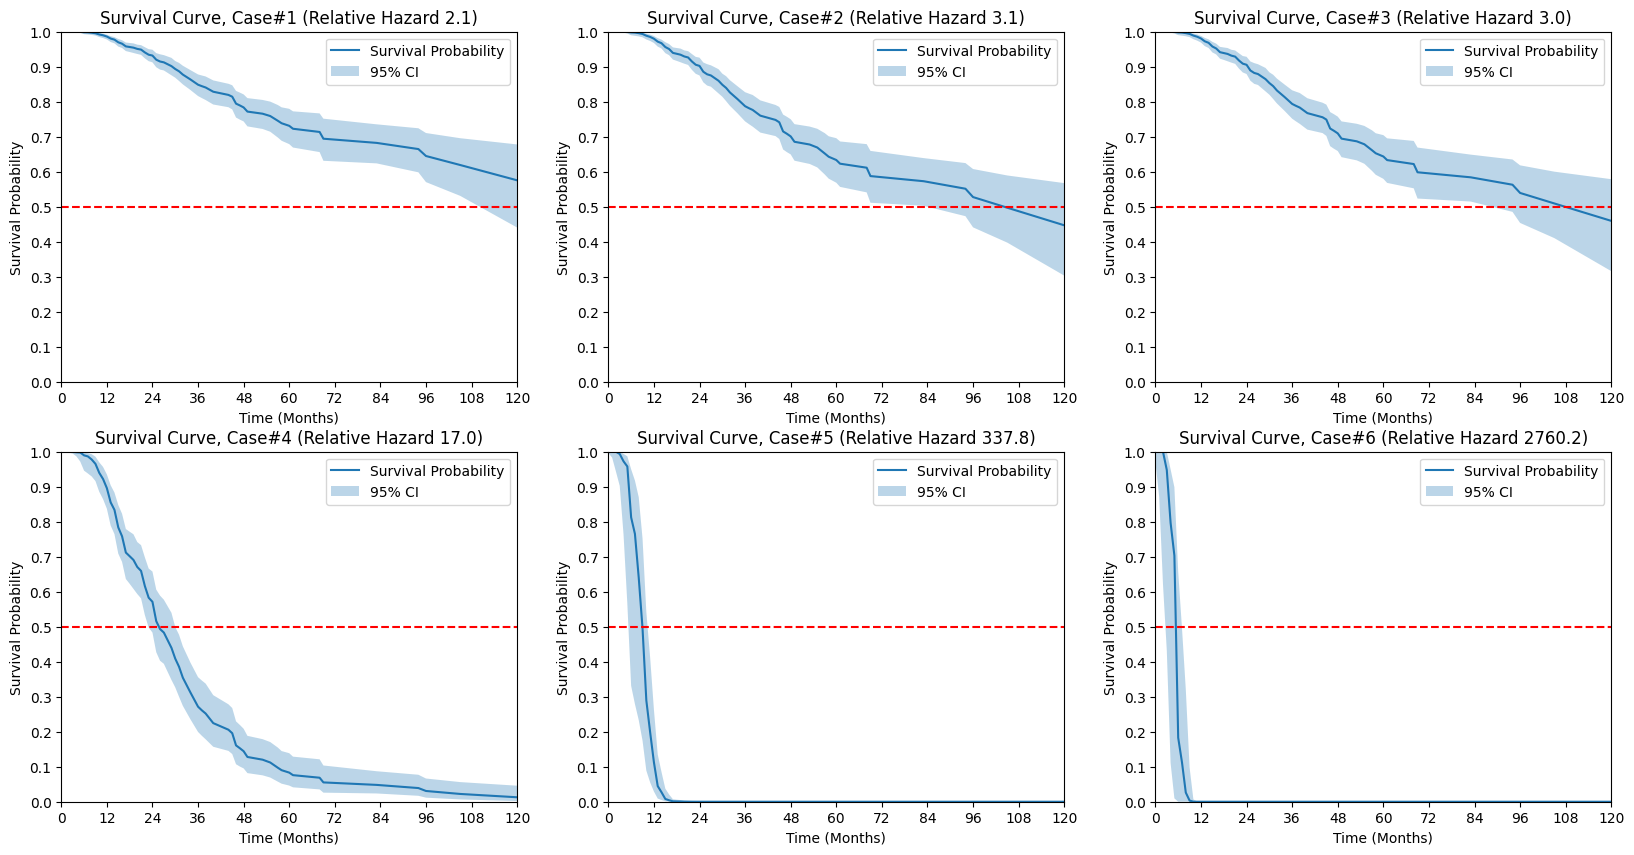

In [120]:
# Full Pipeline
X = load_data(filename=SAMPLE_DATA_CSV)[INP_FEATURES]
model_dict = load_model_dict(is_complex=IS_COMPLEX)
rh_pred_list = np.exp(run_model(X, model_dict))

df_base_cum_hz = load_baseline_cumulative_hazard(is_complex=IS_COMPLEX)

_, axs = plt.subplots(2, 3, figsize=(20, 10))
axs = axs.flatten()

for idx in range(len(rh_pred_list)):
    rh_pred = rh_pred_list[idx]
    df_hz = df_base_cum_hz.copy()

    df_hz['H_median'] = df_hz['H0_median'] * rh_pred
    df_hz['H_lower']  = df_hz['H0_lower']  * rh_pred
    df_hz['H_upper']  = df_hz['H0_upper']  * rh_pred

    df_hz['S_median'] = np.exp(-df_hz['H_median'])
    df_hz['S_lower']  = np.exp(-df_hz['H_upper'])
    df_hz['S_upper']  = np.exp(-df_hz['H_lower'])

    plot_survival_curve(
        time=df_hz['time'],
        s_median=df_hz['S_median'],
        s_lower=df_hz['S_lower'],
        s_upper=df_hz['S_upper'],
        title=f'Survival Curve, Case#{idx+1} (Relative Hazard {rh_pred:.1f})',
        ax=axs[idx]
    )

plt.show()